In [7]:
import json
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
import data_collection
import tokenization
import train_model

Build categories_model


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 transcript_input (InputLayer)  [(None, 25)]         0           []                               
                                                                                                  
 word_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 embedding_6 (Embedding)        (None, 25, 8)        31528       ['transcript_input[0][0]']       
                                                                                                  
 embedding_7 (Embedding)        (None, 1, 4)         15764       ['word_input[0][0]']             
                                                                                            

2022-04-08 17:44:53.567675: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-08 17:44:53.891316: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-08 17:44:53.891369: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-08 17:44:53.902536: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-08 17:44:54.029860: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-08 17:44:54.044730: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-08 17:44:54.060308: I tensorflow/core/grappler/optimizers/cust

1637/1637 - 64s - loss: 0.1532 - acc: 0.8534 - val_loss: 0.0698 - val_acc: 0.9505 - 64s/epoch - 39ms/step
Epoch 2/3
1637/1637 - 62s - loss: 0.0587 - acc: 0.9580 - val_loss: 0.0437 - val_acc: 0.9691 - 62s/epoch - 38ms/step
Epoch 3/3
1637/1637 - 62s - loss: 0.0389 - acc: 0.9709 - val_loss: 0.0319 - val_acc: 0.9752 - 62s/epoch - 38ms/step


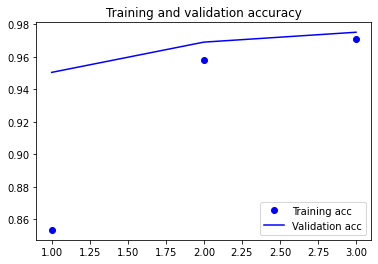

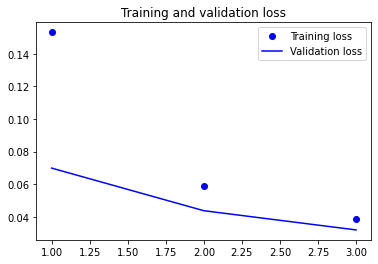

[[9.4375652e-01 3.9576095e-02 3.7496357e-09 2.4018828e-04 7.8207739e-02]
 [9.2586334e-04 9.7212666e-01 6.0984446e-03 1.0257581e-03 1.8706843e-06]
 [5.0284882e-10 6.6759856e-03 9.9875641e-01 5.5276658e-03 4.9994048e-04]
 [4.5596533e-03 2.1269883e-03 1.4103154e-02 9.9649036e-01 1.9348138e-04]
 [3.1756321e-07 2.0328920e-05 7.9389820e-03 4.9630145e-04 9.7849494e-01]
 [2.7571411e-07 1.7558630e-05 1.8520314e-03 4.7081117e-05 9.9388254e-01]]


2022-04-08 17:47:59.613886: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-08 17:47:59.713692: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-08 17:47:59.713790: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-08 17:47:59.721453: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [8]:
# collecting data
data_from_j = open('dataset_for_domain.json', 'r')
json_data_dic = json.loads(data_from_j.read())
data_from_j.close()

dialogue = []
for data in json_data_dic:
    dialogue.append(data['dialogue'])

transcript_label_pair = []
for conversation in dialogue:
    for turn in conversation:
        transcript_label_pair.append({'transcript': turn['transcript'], 'turn_label': turn['turn_label']})

price_range, name, time, food, ignore_word = [], [], [], [], []
categories_message_with_label = []
for pair in transcript_label_pair:
    labeled_transcript = pair['transcript']
    label_list = pair['turn_label']
    categories_turn_label = [0, 0, 0, 0, 0] # price, name, time, food, useless
    for label in label_list:
        if label[0] == 'restaurant-pricerange' or label[0] == 'hotel-pricerange':
            price_range.append({'transcript': labeled_transcript, 'label': label[1], 'key_label': [1, 0, 0, 0, 0]})
            categories_turn_label[0] = 1
        elif label[0] == 'hotel-name' or label[0] == 'restaurant-name' or label[0] == 'taxi-departure'\
                or label[0] == 'taxi-departure' or label[0] == 'taxi-destination' or label[0] == 'attraction-name'\
                or label[0] == 'train-departure' or label[0] == 'train-destination':
            name.append({'transcript': labeled_transcript, 'label': label[1], 'key_label': [0, 1, 0, 0, 0]})
            categories_turn_label[1] = 1
        elif label[0] == 'restaurant-book time' or label[0] == 'train-arriveby' or label[0] == 'train-leaveat'\
                or label[0] == 'taxi-arriveby' or label[0] == 'taxi-leaveat':
            time.append({'transcript': labeled_transcript, 'label': label[1], 'key_label': [0, 0, 1, 0, 0]})
            categories_turn_label[2] = 1
        elif label[0] == 'restaurant-food':
            food.append({'transcript': labeled_transcript, 'label': label[1], 'key_label': [0, 0, 0, 1, 0]})
            categories_turn_label[3] = 1
    categories_message_with_label.append({'transcript': labeled_transcript, 'categories_label': categories_turn_label})


In [ ]:
# train categories model
# preprocessing
print("Build categories_model")
message_without_empty_label = []
for pair in categories_message_with_label:
    if pair['categories_label'] != [0, 0, 0, 0]:
        message_without_empty_label.append(pair)

categories_train = message_without_empty_label[4000:]
categories_test = message_without_empty_label[:4000]
categories_train_message, categories_train_label = [], []
for categories_pair in categories_train:
    categories_train_message.append(categories_pair['transcript'])
    categories_train_label.append(categories_pair['categories_label'])
categories_test_message, categories_test_label = [], []
for categories_pair in categories_test:
    categories_test_message.append(categories_pair['transcript'])
    categories_test_label.append(categories_pair['categories_label'])

# Dictionary    !!! Tokenizer !!!
tokenizer, padded_tokenized_message_train, padded_tokenized_message_test = \
    tokenization.tokenize_message(categories_train_message, categories_test_message)
categories_train_dataset = [padded_tokenized_message_train, categories_train_label]
categories_test_dataset = [padded_tokenized_message_test, categories_test_label]
# train model part
# train_model.categories_model(tokenizer, categories_train_dataset, categories_test_dataset)

# keyboard model
# show data size
price_range_train, price_range_test = price_range[1000:], price_range[:1000]
name_train, name_test = name[2000:], name[:2000]
time_train, time_test = time[900:], time[:900]
food_train, food_test = food[1000:], food[:1000]
# split dataset to train and test
train_dataset = price_range_train + name_train + time_train + food_train
test_dataset = price_range_test + name_test + time_test + food_test

total_data = price_range_train + name_train + time_train + food_train \
             + price_range_test + name_test + time_test + food_test

# collect word is not useful for fifth tag
key_word, target_word = [], []
for element in total_data:  # collect all the keyword
    if element['label'] not in key_word:
        key_word.append(element['label'])
all_transcript, useless = [], []
for element in total_data:  # add word to target_word if the word not in keyword
    all_transcript.append(element['transcript'])
for sentence in all_transcript:
    sentence_word_list = sentence.split(' ')
    for word in sentence_word_list:
        if word not in key_word:
            useless.append({'transcript': sentence, 'label': word, 'key_label': [0, 0, 0, 0, 1]})

# add useless in train and test
train_dataset = price_range_train + name_train + time_train + food_train + useless[5000:25000]
test_dataset = price_range_test + name_test + time_test + food_test + useless[:5000]

hold_transcript, key_word, key_label = [], [], []
for turn in train_dataset:
    hold_transcript.append(turn['transcript'])  # input data
    key_word.append(turn['label'])  # input data
    key_label.append(turn['key_label'])  # output data

#   tokenize the word in sentences
print(hold_transcript)
tokenized_transcript = tokenizer.texts_to_sequences(hold_transcript)
tokenized_key_word = tokenizer.texts_to_sequences(key_word)
padded_tokenized_transcript = pad_sequences(tokenized_transcript, maxlen=25, padding='post', truncating='post')
padded_tokenized_key_word = pad_sequences(tokenized_key_word, maxlen=1, padding='post', truncating='post')

# model structure
vocab_size = len(tokenizer.word_index) + 1
transcript_input = tf.keras.Input(shape=(25,), name="transcript_input")
word_input = tf.keras.Input(shape=(1,), name="word_input")
transcript_features = tf.keras.layers.Embedding(vocab_size, 8)(transcript_input)
word_features = tf.keras.layers.Embedding(vocab_size, 4)(word_input)
transcript_features = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32))(transcript_features)
word_features = tf.keras.layers.LSTM(8)(word_features)
combine_layer = tf.keras.layers.concatenate([transcript_features, word_features])
control_range_layer = tf.keras.layers.Dense(8, activation='linear')(combine_layer)
key_word_output = tf.keras.layers.Dense(5, name="stage_output", activation='sigmoid')(control_range_layer)
word_classify_model = tf.keras.Model(
    inputs=[transcript_input, word_input],
    outputs=[key_word_output],
)
word_classify_model.compile(loss=['binary_crossentropy'], optimizer='adam', metrics=['acc'])
print(word_classify_model.summary())
tf.keras.utils.plot_model(word_classify_model, 'transcript_model.png', show_shapes=True)

history = word_classify_model.fit({"transcript_input": padded_tokenized_transcript, "word_input": padded_tokenized_key_word},
                                  np.array(key_label), epochs=3,
                                  validation_data=({"transcript_input": padded_tokenized_transcript,
                                            "word_input": padded_tokenized_key_word},
                                           np.array(key_label)), verbose=2)
train_model.plot_model_accurate(history)  # plot graph
word_classify_model.save('transcript_model.h5')


In [ ]:
# test the model
sentence = ["hello, I would like to book a cheap hotel", "Book a table at 16:00 University",
            "hello, book a table at 16:00", "Want to find some japanese food",
            "Want to find some japanese food", "Want to find some japanese food"]
sequences = tokenizer.texts_to_sequences(sentence)

# input layer data text
padded = pad_sequences(sequences, maxlen=25, padding='post', truncating='post')
word = ['cheap', 'University', '16:00', 'japanese', 'some', 'to']
word = tokenizer.texts_to_sequences(word)
padded_word = pad_sequences(word, maxlen=1, padding='post', truncating='post')

print(
    word_classify_model.predict({"transcript_input": padded, "word_input": padded_word})
)

